# Quadruped Forward/Inverse Kinematics
---
Kevin Walchko
Created: 24 Oct 2016

# Denavit-Hartenberg (DH)

Development of the DH forward kinematics for a quadruped robot. We will use the DH method to develop the symbolic equations and use python to simplify them.

![](https://github.com/walchko/pyGeckoRobots/blob/master/quadruped/robotis/docs/spider.png?raw=true)



In [108]:
%matplotlib inline

In [109]:
from __future__ import print_function
from __future__ import division
import numpy as np
from sympy import symbols, sin, cos, pi, simplify
from math import radians as d2r
from math import degrees as r2d
from math import atan2, sqrt, acos, fabs

In [110]:
t1, t2, t3 = symbols('t1 t2 t3')
Lc, Lf, Lt = symbols('Lc Lf Lt')

The following class follows the traditional [DH convention](https://en.wikipedia.org/wiki/Denavit%E2%80%93Hartenberg_parameters). Where:

| Parameter | Definition|
|-----------|-----------|
| $\alpha_i$   | angle about common normal, from old z axis to new z axis (twist)|
| $d_i$        | offset along previous z to the common normal |
| $\theta_i$   | angle about previous z, from old x to new x |
| $a_i$        | length of the common normal. Assuming a revolute joint, this is the radius about previous z. |

In [111]:
class DH(object):
    def __init__(self):
        pass

    def fk(self, params):
        t = np.eye(4)
        for p in params:
            t = t.dot(self.makeT(*p))
        return t

    def makeT(self, a, alpha, d, theta):
        return np.array([  # classic DH
            [cos(theta), -sin(theta) * cos(alpha),  sin(theta) * sin(alpha), cos(theta) * a],
            [sin(theta),  cos(theta) * cos(alpha), -cos(theta) * sin(alpha), sin(theta) * a],
            [         0,               sin(alpha),               cos(alpha),              d],
            [         0,                        0,                        0,              1]
        ])

In [112]:
def eval(f, inputs):
    h = []
    for i in range(0, 3):
        tmp = (f[i,3]).subs(inputs)
        h.append(tmp.evalf())
    return h

The parameters are:

| i |$a_i$        | $\alpha_i$   | $d_i$   | $theta_i$  |
|---|-------------|--------------|---------|------------|
| 1 | $L_{coxa}$  | 90           | 0       | $\theta_1$ |
| 2 | $L_{femur}$ | 0            | 0       | $\theta_2$ |
| 3 | $L_{tibia}$ | 0            | 0       | $\theta_3$ |


In [113]:
# a, alpha, d, theta
params = [
    [Lc, pi/2, 0, t1],
    [Lf,    0, 0, t2],
    [Lt,    0, 0, t3]
]
dh = DH()
t = dh.fk(params)
t = eval(t,[])

In [114]:
for i in t:
    print(simplify(i))

1.0*(Lc + Lf*cos(t2) + Lt*cos(t2 + t3))*cos(t1)
1.0*(Lc + Lf*cos(t2) + Lt*cos(t2 + t3))*sin(t1)
1.0*Lf*sin(t2) + 1.0*Lt*sin(t2 + t3)


In [115]:
def fk(t1, t2, t3, Lc, Lf, Lt):
    t1 = d2r(t1)
    t2 = d2r(t2)
    t3 = d2r(t3)
    return np.array([
        (Lc + Lf*cos(t2) + Lt*cos(t2 + t3))*cos(t1),
        (Lc + Lf*cos(t2) + Lt*cos(t2 + t3))*sin(t1),
        Lf*sin(t2) + 1.0*Lt*sin(t2 + t3)
    ])

# Inverse Kinematics

Often, we need to find the angles of the leg joints given a location (x,y,z) of the foot. To calculate this, remember the leg is composed of 3 revolute joints. The shoulder is in one plane and both the femur joint and tibia joint are in another plane.

**insert picture here**

## Useful Trigonometry

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/49/Triangle_with_notations_2.svg/200px-Triangle_with_notations_2.svg.png)

The **law of cosines** for calculating one side of a triangle when the angle
opposite and the other two sides are known. Can be used in conjunction with
the law of sines to find all sides and angles.

## Derivation

So let's start with the shoulder, look down from the top, we see the x-y plane. We can calculate the it's rotation $\theta_1$ by using x and y of the foot location.

$$\theta_1 = atan2(y,x)$$

Next, let's look at the plane which the next 2 joints lie in. Now we will calculate the $\theta_2$ and $\theta_3$ angles.

$$ m = \sqrt{x^2 + y^2} $$

$$ f = m - L_{coxa} $$

$$ \beta_1 = atan2(f,z) $$

$$ d = \sqrt{f^2 + z^2} $$

$$ \beta_2 = \arccos( \frac{L_{femur}^2+d^2-L_{tibia}^2}{2 d L_{femur}} ) $$

$$ \theta_2 = \beta_1 + \beta_2 $$

$$\theta_3 = \arccos( \frac{L_{femur}^2+L_{tibia}^2-d^2}{2 L_{femur} L_{tibia}} ) $$

Now finally, you should notice the definition is different between forward and reverse kinematics. So let's fix that ...


$$ \theta_{2fk} = \theta_{2ik} - \pi $$
$$ \theta_{3fk} = \theta_{3ik} - \pi/2 $$


In [116]:
def ik(x, y, z, Lc, Lf, Lt):
    t1 = atan2(y, x)
    f = sqrt(x**2 + y**2) - Lc
    
    # depending on z, you have to do a different atan
    if z < 0.0:
        b1 = atan2(f, fabs(z))
    else:
        b1 = atan2(z, f)
    d = sqrt(f**2 + z**2)  
    b2 = acos((Lf**2 + d**2 - Lt**2) / (2.0 * Lf * d))
    t2 = b1 + b2
    t3 = acos((Lf**2 + Lt**2 - d**2) / (2.0 * Lf * Lt))

    t3 -= pi  # fix to align fk and ik frames
    if z < 0.0:
        t3 -= pi/2

    return [r2d(t1), r2d(t2),r2d(t3)]

In [117]:
pts = fk(0.0,45.,-60., 10., 40., 100.)
# print(type(pts[1]))
print('pts: {:.3f} {} {:.3f}'.format(*pts))

angles = ik(pts[0], pts[1], pts[2], 10, 40, 100)
print('angles: {:.1f} {:.1f} {:.1f}'.format(*angles))

pts: 134.877 0 2.402
angles: 0.0 45.0 -60.0


In [118]:
# from random import uniform
# for i in range(10):
#     a=uniform(-90,90)
#     b=uniform(0,90)
#     c=uniform(-180,0)
#     pts = fk(a,b,c, 10, 40, 100)
#     angles = ik(pts[0], pts[1], pts[2], 10, 40, 100)
#     if angles:
#         if a-angles[0]>0.1 or b-angles[1]>0.1 or c-angles[2]>0.1:
#             print('in: {:.1f} {:.1f} {:.1f} out: {:.1f} {:.1f} {:.1f}'.format(a,b,c, *angles))

In [119]:
# def printError(pts, pts2, angles, angles2):
#     print('****************************************************')
#     print('angles (orig):', angles)
#     print('angles2 from ik(pts): {:.2f} {:.2f} {:.2f}'.format(*angles2))
#     print('pts from fk(orig): {:.2f} {:.2f} {:.2f}'.format(*pts))
#     print('pts2 from fk(angle2): {:.2f} {:.2f} {:.2f}'.format(*pts2))
#     print('diff [deg]: {:.2f}'.format(np.linalg.norm(np.array(angles) - np.array(angles2))))
#     print('diff [mm]: {:.2f}'.format(np.linalg.norm(pts - pts2)))
#     print('\nExiting\n')
#     print('****************************************************')

# def fk_ik():
#     cox = 10
#     fem = 40
#     tib = 100
#     for a in range(-45, 45, 5):
#         for b in range(0,90,5):
#             for g in range(-90,0,5):
#                 print('------------------------------------------------')
#                 a1 = [a,b,g]
#                 pts = fk(a1[0],a1[1],a1[2], cox, fem, tib)
#                 a2 = ik(pts[0], pts[1], pts[2], cox, fem, tib)
#                 pts2 = fk(a2[0], a2[1], a2[2], cox, fem, tib)

#                 print('points:', pts)
# #                 print(type(pts))
# #                 print(pts - pts2)
# #                 print(np.linalg.norm(pts - pts2))
                
# #                 print(a1)
# #                 print(type(a1))
# #                 print(a2)
# #                 print(type(a2))

#                 angle_error = np.linalg.norm(np.array(a1) - np.array(a2))
#                 pos_error = np.linalg.norm(pts - pts2)
#                 # print(angle_error, pos_error)

#                 if angle_error > 0.0001:
#                     print('Angle Error')
#                     printError(pts, pts2, angles, angles2)
#                     exit()

#                 elif pos_error > 0.0001:
#                     print('Position Error')
#                     printError(pts, pts2, angles, angles2)
#                     exit()

#                 else:
#                     print('Angle: {:.1f} {:.1f} {:.1f}'.format(angles[0], angles[1], angles[2]))
#                     print('Pos: {:.1f} {:.1f} {:.1f}'.format(pts[0], pts[1], pts[2]))
#                     print('Error(deg,mm): {:.2f} {:.2f}\n'.format(angle_error, pos_error))
        
# fk_ik()

## Loading

In [142]:
def calcTorque(foot, Lc, Lf, Lt):
    """
    s     s
    +-----+--------+ CM
    |              |
    |              v
    |
        torque balance:  s + s = r W/3
    the servos are at location s, the center mass is at CM, the weight is W
    and r is the distance from the foot to CM. The shoulder servo works perpendicular
    to this plane and doesn't help to lift.
    """
    # servo = 0.15  # TG9e servo torque in Nm
    servo = 0.39  # XL-320 servo torque in Nm

    x = 0.001*sqrt(foot[0]**2 + foot[1]**2)  # convert to mm
    r = .144/2 + x

    # 2*servo = r F
    F = 2.0*servo/r  # 2 servos per leg lifting
    return 3.0*F  # 3 legs are lifting at all times

Lc = 40
Lf = 50
Lt = 100
robot_weight = 560
foot = fk(0,0,-45, Lc, Lf, Lt)
print('Foot location {:.3f} {} {:.3f}'.format(*foot))
N = calcTorque(foot, Lc, Lf, Lt)
print('This can lift {:.3f} N'.format(N))

# why the fuck do people confuse mass and weight!!! weight is N and mass is kg
# the the stupid scale I used was in grams for weight ... idiots!!!
G = 1000*N/9.81
print('This can lift {:.3f} gram force'.format(G))  # convert N to grams force
print('The robot is: {} gram force'.format(robot_weight))
print('Factor of safety: {:.2f}'.format(G/robot_weight))

Foot location 160.711 0 -70.711
This can lift 10.055 N
This can lift 1025.016 gram force
The robot is: 560 gram force
Factor of safety: 1.83


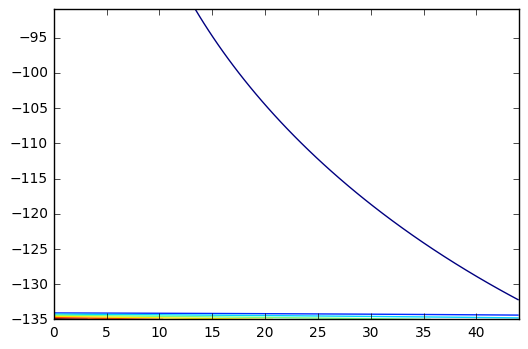

In [138]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np

# fig = plt.figure()
# ax = fig.gca(projection='3d')
x = np.arange(0, 45, 1.0)
y = np.arange(-135, -90, 1.0)
# X, Y = np.meshgrid(X, Y)
# x = range(0, 25)
# y = range(-115, -90)
Z = []
for femur in x:
    z=[]
    for tibia in y:
#         print('{} {}'.format(femur, tibia))
        pos = ik(0, femur, tibia, Lc, Lf, Lt)
        N = calcTorque(pos, Lc, Lf, Lt)
        G = 1000*N/9.81
        z.append(G/robot_weight)
    Z.append(z)

X, Y = np.meshgrid(x, y)
# ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
#                        linewidth=0, antialiased=False)
# ax.plot_surface(X, Y, Z);
plt.figure()
plt.contour(X,Y,Z)

In [ ]:
import matplotlib.pyplot as plt

plt.subplot(2,2,1);
plt.plot(px)
plt.ylabel('x')

plt.subplot(2,2,2)
plt.plot(py)
plt.ylabel('y')

plt.subplot(2,2,3);
plt.plot(pz)
plt.ylabel('z')

plt.subplot(2,2,4);
plt.plot(px,py)
plt.ylabel('y')
plt.xlabel('x');

In [141]:
# X = np.arange(-5, 5, 1)
# Y = np.arange(-5, 5, 1)
# X, Y = np.meshgrid(X, Y)
# Z = X*Y**2
print(min(Z))
print(max(Z))


[2.504222149033725, 2.4963540261850667, 2.4885081150180484, 2.4806823952575257, 2.4728749638433474, 2.46508401101995, 2.4573078014530436, 2.449544659058725, 2.441792954614027, 2.434051095477367, 2.4263175169262965, 2.418590674745451, 2.410869038787181, 2.4031510872919695, 2.3954353018032073, 2.3877201625459046, 2.380004144165171, 2.3722857117400555, 2.3645633170032903, 2.3568353947088734, 2.3491003590981387, 2.3413566004215025, 2.3336024814780476, 2.325836334138798, 2.31805645582209, 2.3102611058912648, 2.302448501945887, 2.2946168159781037, 2.286764170365552, 2.27888863367154, 2.2709882162219603, 2.2630608654266937, 2.255104460810975, 2.2471168087193885, 2.239095636651749, 2.231038587186036, 2.222943211438718, 2.2148069620071618, 2.2066271853321084, 2.1984011134104833, 2.1901258547796147, 2.181798384683306, 2.1734155343176336, 2.16497397903961, 2.1564702254044295]
[5.046232325476267, 4.963020212204364, 4.8860776088721645, 4.814493428123452, 4.7475454377368544, 4.684650672301162, 4.625

In [136]:
# print(Z.shape)
print(Z)

[[5.046232325476267, 4.963020212204364, 4.8860776088721645, 4.814493428123452, 4.7475454377368544, 4.684650672301162, 4.625331276076229, 4.569190312601713, 4.515894219724666, 4.465159818548925, 4.416744518353841, 4.370438811946948, 4.326060443236347, 4.283449816058992, 4.242466338173972], [2.6136561843761834, 2.6102157405465527, 2.606620760893629, 2.6028927665807555, 2.5990491281353596, 2.5951040920179964, 2.5910695010011104, 2.586955313194338, 2.58276998457498, 2.5785207565314057, 2.5742138757739137, 2.5698547651089414, 2.5654481578691666, 2.56099820502741, 2.5565085614814635], [2.611654160747021, 2.6080531454844267, 2.6043076765559423, 2.600437538576822, 2.5964587670461685, 2.59238455796085, 2.5882259108707473, 2.583992095140166, 2.5796909954796674, 2.5753293729232616, 2.5709130652620327, 2.5664471432718736, 2.561936034098321, 2.5573836198576694, 2.5527933172713], [2.609573814317721, 2.6058175992005506, 2.601926234581633, 2.597917942294212, 2.5938075471899644, 2.589607286304463, 2.58


-----------

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.